In [41]:
import torch
import numpy as np
import pandas as pd

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

torch.manual_seed(611)

In [42]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [43]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [44]:
features = 'VGGish'#'PANNs'#'YAMNet' #'VGGish'#'AI'
mod_encoder = 'GAT'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [45]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

RZUA01
Data1.shape=torch.Size([3, 24, 128])
RZUA02
Data1.shape=torch.Size([3, 24, 128])
RZUA04
Data1.shape=torch.Size([3, 24, 128])
RZUA05
Data1.shape=torch.Size([3, 24, 128])
RZUA06
Data1.shape=torch.Size([3, 24, 128])
RZUA07
Data1.shape=torch.Size([3, 24, 128])
RZUA08
Data1.shape=torch.Size([3, 24, 128])
RZUA09
Data1.shape=torch.Size([3, 24, 128])
RZUA10
Data1.shape=torch.Size([3, 24, 128])
RZUB01
Data1.shape=torch.Size([3, 24, 128])
RZUB03
Data1.shape=torch.Size([3, 24, 128])
RZUB04
Data1.shape=torch.Size([3, 24, 128])
RZUB05
Data1.shape=torch.Size([3, 24, 128])
RZUB06
Data1.shape=torch.Size([3, 24, 128])
RZUB07
Data1.shape=torch.Size([3, 24, 128])
RZUB08
Data1.shape=torch.Size([3, 24, 128])
RZUB09
Data1.shape=torch.Size([3, 24, 128])
RZUB10
Data1.shape=torch.Size([3, 24, 128])
RZUB11
Data1.shape=torch.Size([3, 24, 128])
RZUC01
Data1.shape=torch.Size([3, 24, 128])
RZUC02
Data1.shape=torch.Size([3, 24, 128])
RZUC03
Data1.shape=torch.Size([3, 24, 128])
RZUC05
Data1.shape=torch.Size([3

In [46]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [47]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 128])

## Edge Creation

In [48]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [49]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True


128

In [50]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [51]:
del x, unpacked_data, train_dataset

## Cargar modelo

In [52]:
from models import MatrixGCNVAE_MT, MatrixGATVAE_MT

In [53]:
if mod_encoder == "GCN":
    model = MatrixGCNVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
elif mod_encoder == "GAT":
    model = MatrixGATVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
else:
    print("Error")

In [54]:
#load model
model.load_state_dict(torch.load(f'modelsGVAE_semi/{features}_{mod_encoder}_model_weights.pth'))

<All keys matched successfully>

In [55]:
from torchsummary import summary
print(summary(model))

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            1,600
├─GATv2Conv: 1-2                         --
|    └─SumAggregation: 2-1               --
|    └─Linear: 2-2                       4,194,816
|    └─Linear: 2-3                       4,194,816
├─BatchNorm1d: 1-3                       1,024
├─GATv2Conv: 1-4                         --
|    └─SumAggregation: 2-4               --
|    └─Linear: 2-5                       8,208
|    └─Linear: 2-6                       8,208
├─GATv2Conv: 1-5                         --
|    └─SumAggregation: 2-7               --
|    └─Linear: 2-8                       8,208
|    └─Linear: 2-9                       8,208
├─Linear: 1-6                            8,704
├─Linear: 1-7                            1,575,936
├─Sequential: 1-8                        --
|    └─Linear: 2-10                      8,704
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      47,196
├─Sequential: 1-9     

## Eval


In [56]:
# Generate embeddings
model.eval()
model.double()
embeddings = torch.empty(92,0)
with torch.no_grad():
    for graph in train_loader:
        _, _, mu, logvar,_ = model(graph.x.double(), graph.edge_index)
        embs = model.reparameterize(mu, logvar)
        embeddings = torch.cat((embeddings,mu), dim = 1)

In [57]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 48])


In [58]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [59]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)/int(num_feat/8)
sim_mat

array([[0.79881289, 0.79873256, 0.66119792, ..., 0.56748702, 0.65364126,
        0.66008058],
       [0.79873256, 0.79865312, 0.66130397, ..., 0.5674716 , 0.65370886,
        0.66005838],
       [0.66119792, 0.66130397, 1.02126973, ..., 0.74878789, 0.91938846,
        0.81764629],
       ...,
       [0.56748702, 0.5674716 , 0.74878789, ..., 1.02013347, 0.84833095,
        0.74127406],
       [0.65364126, 0.65370886, 0.91938846, ..., 0.84833095, 1.0536185 ,
        0.82417084],
       [0.66008058, 0.66005838, 0.81764629, ..., 0.74127406, 0.82417084,
        0.80510024]])

In [60]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [62]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

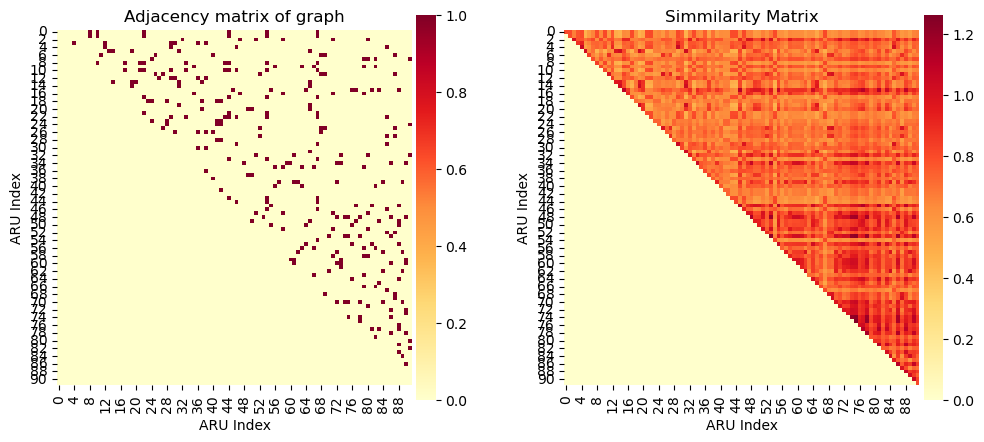

In [63]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

## Post-process graph

In [81]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=13)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 48], edge_index=[2, 1498]) connected? True
Is the graph undirected True


In [82]:
adj_init = edge_index_to_adjacency(graph.edge_index)
adj_final = edge_index_to_adjacency(graphs_[0].edge_index)

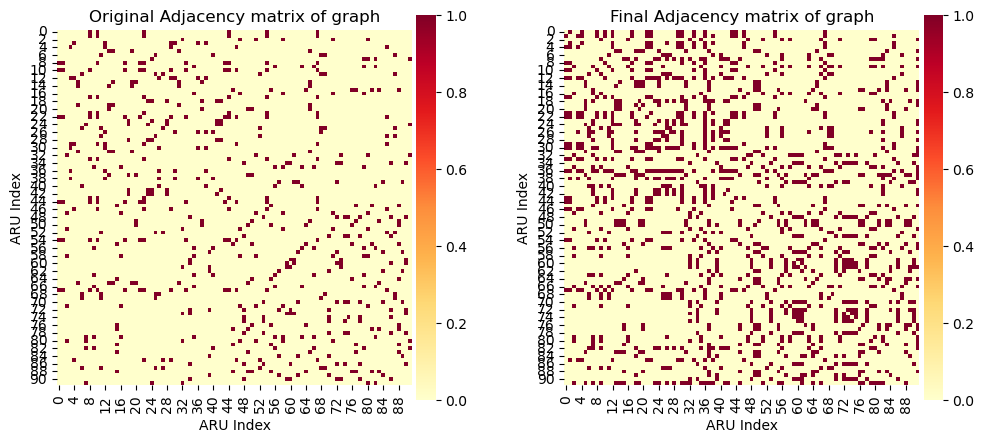

In [83]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(adj_init, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Original Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
# sns.heatmap(adj_final*sim_mat, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
sns.heatmap(adj_final, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Final Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

In [84]:
import networkx as nx

def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges with weights if available
    edges = data.edge_index.t().numpy()
    
    # Check if edge weights are available
    if hasattr(data, 'edge_weight') and data.edge_weight is not None:
        # Add edges with weights
        edge_weights = {tuple(edge): weight.item() for edge, weight in zip(edges, data.edge_weight)}
        for edge, weight in edge_weights.items():
            G.add_edge(edge[0], edge[1], weight=weight)
    else:
        # Add edges without weights
        G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [85]:
import geopandas as gpd

#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

coordinates = same_posicion_data(df_map)

In [86]:
def adjacency_to_edge_weights(adj_matrix, edge_index):
    """
    Convert adjacency matrix of weights to edge_weight tensor using edge_index.
    
    Args:
        adj_matrix: Tensor of shape [num_nodes, num_nodes] containing edge weights
        edge_index: Tensor of shape [2, num_edges] containing edge indices
        
    Returns:
        edge_weight: Tensor of shape [num_edges] containing weights for each edge
    """
    # Get source and target nodes for each edge
    src, dst = edge_index[0], edge_index[1]
    
    # Extract weights from adjacency matrix based on edge indices
    edge_weight = adj_matrix[src, dst]
    
    return edge_weight

In [87]:
edge_weight = adjacency_to_edge_weights(sim_mat, graphs_[0].edge_index)
edge_weight.shape

(1498,)

In [88]:
graphs_[0].edge_weight = edge_weight

In [89]:
G = pyg_to_networkx(graphs_[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [90]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 0.7987325634250513}), (0, 4, {'weight': 0.8039662592190715}), (0, 8, {'weight': 0.8019535193859727}), (0, 10, {'weight': 0.8032548188456831}), (0, 12, {'weight': 0.7749559532112044}), (0, 17, {'weight': 0.798845920698138}), (0, 21, {'weight': 0.7957375519114167}), (0, 22, {'weight': 0.804913310995637}), (0, 29, {'weight': 0.8046975780214557}), (0, 30, {'weight': 0.7508108197729721}), (0, 33, {'weight': 0.7988030188047317}), (0, 36, {'weight': 0.7508108197729723}), (0, 43, {'weight': 0.8010018968160724}), (0, 44, {'weight': 0.8009396717997068}), (0, 46, {'weight': 0.8051550607033536}), (0, 54, {'weight': 0.8009396717997068}), (0, 67, {'weight': 0.8049133113237775}), (1, 3, {'weight': 0.776793641221782}), (1, 4, {'weight': 0.803965319824059}), (1, 8, {'weight': 0.801807421492808}), (1, 10, {'weight': 0.8031356300460368}), (1, 12, {'weight': 0.7749263681094543}), (1, 17, {'weight': 0.7987654971441496}), (1, 21, {'weight': 0.7956726549756868}), (1, 22, {'wei

## Métricas

In [91]:
nx.density(G)


0.17892976588628762

In [92]:
nx.diameter(G,weight="weight")

4.008075030323297

In [93]:
nx.average_shortest_path_length(G,weight="weight")

1.907423847737202

In [94]:
# nx.betweenness_centrality(G, weight="weight")
G.remove_node(35)

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


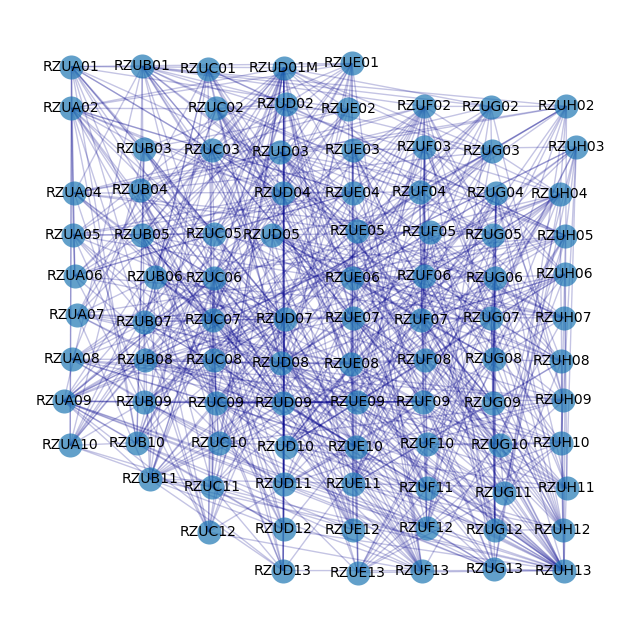

In [95]:
edge_weights = [1 for u, v in G.edges()]
# edge_weights = [3*sim_mat[u,v]  for u, v in G.edges()]

# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer", alpha=0.7)
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo

# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.23) # se puede ver tambien con colores cambiando edge_color=edge_colors
plt.box(False)
fig.savefig('./results/graph_resGAT_VGGish.pdf', transparent=True, dpi=300, bbox_inches='tight',pad_inches=0.0)

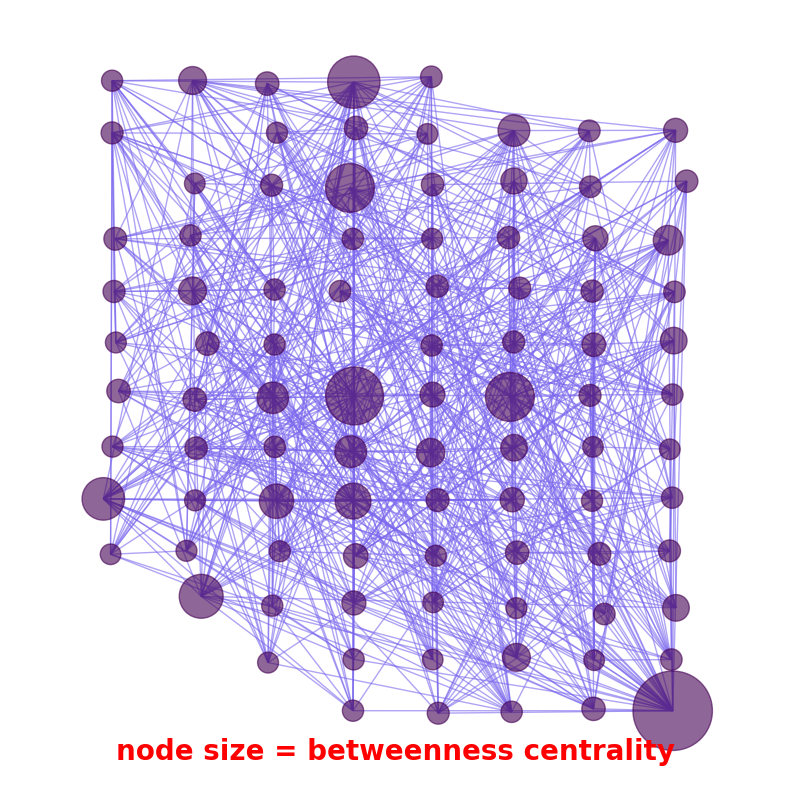

In [96]:
H = G.copy()
# H.remove_node(35)
centrality = nx.betweenness_centrality(H, endpoints=True) #k=10

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
    alpha=0.6,
)

# Title/legend
font = {"color": "r", "fontweight": "bold", "fontsize": 20}


ax.text(
    0.50,
    0.026,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

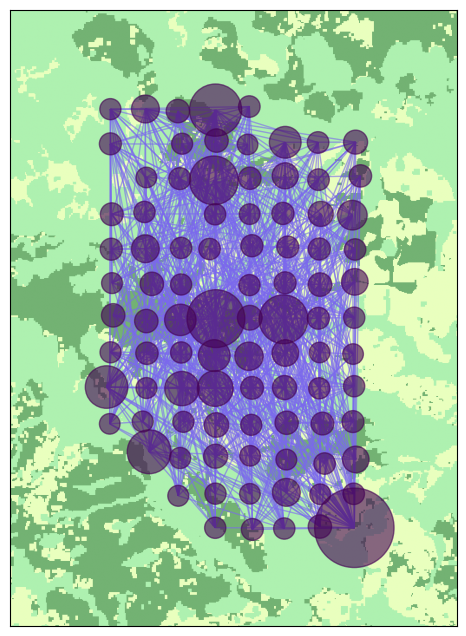

In [97]:
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.plot import show

# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))

colors = [(115/255,178/255,115/255),(233/255,255/255,190/255), (174/255,241/255,176/255)] 
cmap = LinearSegmentedColormap.from_list('my_cmp', colors, N=3)


tif_path = r'./data/wgs84.tif'

img = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize = (8, 8))

# plt.title("COB")
r = rasterio.plot.show(img, cmap=cmap, ax=ax)

# im = r.get_images()[0]
# fig.colorbar(im, ax=ax)

centrality = nx.betweenness_centrality(H, endpoints=True) #k = 10

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
    alpha=0.6,
)


margin = 0.01
ax.set_xlim(bounds[2]-margin, bounds[3]+margin)
ax.set_ylim(bounds[0]-margin, bounds[1]+margin)

fig.savefig(f'./results/graph_eb_geo_{features}_{mod_encoder}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)
plt.show()


## Fin